In [1]:
!pip install seaborn
!pip install ipywidgets
#!pip install hypnettorch

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 293 kB 9.1 MB/s eta 0:00:01
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 139 kB 9.0 MB/s eta 0:00:01
     |████████████████████████████████| 2.3 MB 52.4 MB/s eta 0:00:01
     |████████████████████████████████| 214 kB 122.8 MB/s eta 0:00:01


In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import torch
import torch.distributions as dist
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import scipy.stats
from tqdm.notebook import tqdm
from datetime import datetime
#%matplotlib notebook
random_seed = 1
np.random.seed(seed=1)
torch.manual_seed(2)
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
path = os.path.join(os.getcwd(), "plot/")
today=datetime.today().strftime('%Y-%m-%d')

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
class FHatNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(FHatNetwork, self).__init__()
        layers = []
        if hidden_sizes == []:
            self.model = nn.Linear(input_size, output_size)
        else:
            layers.append(nn.Linear(input_size, hidden_sizes[0]))
            layers.append(nn.ReLU())
            for i in range(1, len(hidden_sizes)):
                layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
                layers.append(nn.ReLU())
            layers.append(nn.Linear(hidden_sizes[-1], output_size))
            self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)




# Define the target network
class TargetNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(TargetNetwork, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        return self.fc(x)

# Define the hypernetwork
class HyperNetwork(nn.Module):
    def __init__(self, target_net, hyper_input_dim, hyper_hidden_dims):
        super(HyperNetwork, self).__init__()
        self.target_net = target_net
        layers = [] 
        if hyper_hidden_dims == []:
            layers.append(nn.Linear(hyper_input_dim, target_net.fc.weight.numel()))
        else:
            layers.append(nn.Linear(hyper_input_dim, hyper_hidden_dims[0]))
            layers.append(nn.ReLU())
            for i in range(1, len(hyper_hidden_dims)):
                layers.append(nn.Linear(hyper_hidden_dims[i-1],hyper_hidden_dims[i]))
            layers.append(nn.Linear(hyper_hidden_dims[-1], target_net.fc.weight.numel()))
        
        layers.append(nn.Tanh())
        self.model = nn.Sequential(*layers)
        
    def forward(self, x, alpha):
        alpha = alpha.unsqueeze(0)
        params = self.model(alpha)
        params = params.view(self.target_net.fc.weight.size())
        self.target_net.fc.weight.data = params
        return self.target_net(x)

**Preliminaries** In the following, the classes are defined to initiate the aggregation functions $\rho_{\alpha}$ and the aggregated risk minimization (ARM) optimization for a simple 1D and 2D regression task.

In [6]:
class aggregation_function:    
    """ This class aggregates the risks. """
    def __init__(self, name:str):
        self.name = name
    def aggregate(self, risks, alpha) -> float:
        if self.name == 'cvar':
            return self.cvar(risks, alpha)
        else:
            raise NotImplementedError("Currently, only CVaR is implemented.")
    def cvar(self, risks, alpha) -> float:
        var = torch.quantile(risks,alpha, interpolation='linear')
        cvar = risks[risks > var].mean()
        return cvar

In [7]:
class ARM_Regression:
    def __init__(self, name, experiment="1D_linear"):      
        self.aggregator = aggregation_function(name=name)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    def objective_h(self, risks, alpha_prime):
        def pdf_normal_distribution(x, alpha_prime):
            # Create a normal distribution centered at alpha' with std. 1 at alpha'
            likelihood = dist.normal.Normal(loc=alpha_prime, scale=0.1*alpha_prime+1e-7)
            # Calculate the probability density at the point x
            pdf = likelihood.log_prob(x).exp()
            return pdf
        alphas = dist.Uniform(0,1).sample((1000,1)).to(device)
        objective = 0
        weights = pdf_normal_distribution(alphas, alpha_prime)
        cvars = torch.stack([self.aggregator.aggregate(risks,alpha) for alpha in alphas])
        objective = (weights * cvars).mean()
        return objective
    
    def information_sharing(self, h, env_dict):
        learning_rate = 0.01
        num_epochs=100
        loss_fn = torch.nn.MSELoss()        
        optimizer = torch.optim.Adam(h.parameters(), lr=learning_rate)
        scheduler = StepLR(optimizer, step_size=100, gamma=0.5)
        alpha_primes = torch.arange(0,1,0.05).to(self.device)
        for alpha_prime in alpha_primes:        
            print(f"alpha: {alpha_prime}")
            for epoch in range(num_epochs+1):
                risks = torch.stack([loss_fn(env_dict[e]['y'].to(self.device), h(env_dict[e]['x'].to(self.device), alpha_prime)) for e in env_dict.keys()])
                loss = self.objective_h(risks, alpha_prime)
                if epoch % 100 == 0:
                    print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item()}, param:{h.target_net.fc.weight.data.item()}")
                loss.backward()
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
        return
  
    def fit_h(self, h, env_dict):
        learning_rate = 0.01
        num_epochs=100
        loss_fn = torch.nn.MSELoss()        
        optimizer = torch.optim.Adam(h.parameters(), lr=learning_rate)
        scheduler = StepLR(optimizer, step_size=100, gamma=0.5)
        alpha_primes = torch.arange(0,1,0.05).to(self.device)
        for alpha_prime in alpha_primes:        
            print(f"alpha: {alpha_prime}")
            for epoch in range(num_epochs+1):
                risks = torch.stack([loss_fn(env_dict[e]['y'].to(self.device), h(env_dict[e]['x'].to(self.device), alpha_prime)) for e in env_dict.keys()])
                loss = self.aggregator.aggregate(risks, alpha_prime)
                if epoch % 100 == 0:
                    print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item()}, param:{h.target_net.fc.weight.data.item()}")
                loss.backward()
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
        return
    
    def fit_f(self, f, env_dict, alpha):        
        learning_rate = 0.01
        num_epochs= 100
        d = env_dict[0]['x'].shape[1]
        loss_fn = torch.nn.MSELoss()        
        optimizer = torch.optim.Adam(f.parameters(), lr=learning_rate)
        scheduler = StepLR(optimizer, step_size=100, gamma=0.1)
        for epoch in range(num_epochs):
            risks = torch.stack([loss_fn(env_dict[e]['y'].to(self.device),f(env_dict[e]['x'].to(self.device))) for e in env_dict.keys()])
            cvar = self.aggregator.aggregate(risks, alpha)
            cvar.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            if (epoch + 1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {cvar.item()}")
        return 


**Experiment 1** We assume the following *linear* data generation process $$Y(X) = X*\theta_{e}+\epsilon$$ and *nonlinear* data generation process $$Y(X) = sin(X*\theta_{e})+\epsilon$$.

**Experiment 1A** Assume a linear model $Y_{e}=\theta_{e}X+\epsilon$, where $X \sim \mathcal{N}(2,0.2)$ and $\epsilon\sim \mathcal{N}(0,0.1)$. We simulate different environments by drawing $\theta$ from a beta distribution $Beta(0.1,0.2)$. In total, we generate for 25 environments 100 observations each.

**Experiment 1B** Assume the same setting as in Experiment 1, however, in contrast, we simulate different environments by drawing $\theta$ from a uniform distribution $\ \mathcal{U}(0,1)$. In total, we generate for 25 environments 100 observations each.

In [8]:
class data_generator:
    
    """ This class generates the simulation data. """
    

    def __init__(self, envs_train = 25, envs_test = 25, 
                 size_train = 1000, size_test= 100, 
                 theta_dist="uniform",
                 dim=1):
        
        self.envs_train = envs_train
        self.envs_test = envs_test
        self.size_train = size_train
        self.size_test = size_test
        self.theta_dist = theta_dist
        self.dim = dim 
        
    def generate(self) -> dict:           
        env_list_train = [f'e_{i}' for i in range(1,self.envs_train+1,1)]
        env_dict_train = dict(list(enumerate(env_list_train)))
        env_list_test  = [f'e_{i}' for i in range(1,self.envs_test+1,1)]
        env_dict_test  = dict(list(enumerate(env_list_test)))
        
        
        for e_train in env_dict_train.keys():
            if self.theta_dist == "uniform": 
                distribution = dist.Uniform(0, 1)
            else:
                distribution = dist.Beta(0.1, 0.2)
            theta_true = distribution.sample((self.dim,1))
            x_train = dist.normal.Normal(loc=1.0/self.dim, scale=0.5).sample((self.size_train,self.dim))
            noise_train = dist.normal.Normal(loc=0, scale=0.05).sample((self.size_train,self.dim))
            y_train = (1.0/math.sqrt(self.dim))*x_train@theta_true + noise_train
            env_dict_train[e_train] = {'x': x_train,'y': y_train,'theta_true': theta_true}
            
        for e_test in env_dict_test.keys():
            if self.theta_dist == "uniform": 
                distribution = dist.Uniform(0, 1)
            else:
                distribution = dist.Beta(0.1, 0.2)
            theta_true = distribution.sample((self.dim,1))
            x_test = dist.normal.Normal(loc=1.0/self.dim, scale=0.5).sample((self.size_test,self.dim))
            noise_test = dist.normal.Normal(loc=0, scale=0.05).sample((self.size_test,self.dim))
            y_test = (1.0/math.sqrt(self.dim))*x_test@theta_true + noise_test
            env_dict_test[e_test] = {'x': x_test,'y': y_test,'theta_true': theta_true}
            
        return env_dict_train, env_dict_test

In [9]:
# Intitialize the experiment and generate the data
envs_train, envs_test = 250, 25
size_train, size_test = 100 , 100
theta_dist="beta" 
rho="cvar"
dim = 1
generator = data_generator(envs_train, envs_test, size_train, size_test, theta_dist, dim)
data_dict_train, data_dict_test = generator.generate()
# Define some example dimensions
generator = data_generator(envs_train, envs_test, size_train, size_test, theta_dist, dim)
data_dict_train, data_dict_test = generator.generate()
#fig, ax = plt.subplots(1,1, figsize=(8,6))

X_train = [data_dict_train[e]['x'].ravel() for e in data_dict_train.keys()]
X_train = np.array([item for sublist in X_train for item in sublist]).reshape(-1,1)
Y_train = [data_dict_train[e]['y'] for e in data_dict_train.keys()]
Y_train = np.array([item for sublist in Y_train for item in sublist]).reshape(-1,1)

#ax.scatter(y=Y_train, x=X_train, s=3, c="grey", alpha=0.05, label="Training envs")
#ax.legend(loc='upper left')

alpha: 0.0
Epoch [0/100], Loss: 0.3668176531791687, param:-0.29986250400543213
Epoch [100/100], Loss: 0.33619430661201477, param:-0.29986250400543213
alpha: 0.05000000074505806
Epoch [0/100], Loss: 0.34717562794685364, param:-0.29621031880378723
Epoch [100/100], Loss: 0.34716612100601196, param:-0.29621031880378723
alpha: 0.10000000149011612
Epoch [0/100], Loss: 0.3585319221019745, param:-0.2925494313240051


KeyboardInterrupt: 

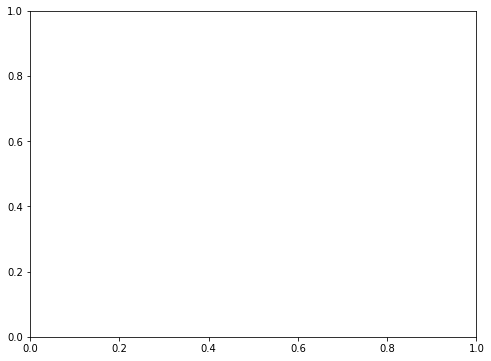

In [14]:
# Instantiate the target network and hypernetwork
target_net = TargetNetwork(input_dim=dim, output_dim=1)
h = HyperNetwork(target_net, hyper_input_dim=1, hyper_hidden_dims=[10]).cuda()
#Run the ARM regression task
loss_fn = torch.nn.MSELoss()
results = pd.DataFrame(columns = ["alpha", "cvar"])
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8,6))
rg = torch.arange(0,1,0.05)
diverging_colors = sns.color_palette("RdBu", len(rg))
ARM_Regression(name=rho).fit_h(h, data_dict_train) 
h.eval()
j=1
for alpha in tqdm(rg):
    with torch.no_grad():
        risks = torch.stack([loss_fn(data_dict_train[e]['y'].cuda(), h(data_dict_train[e]['x'].cuda(), alpha.cuda())) for e in data_dict_train.keys()])
        cvar_emp = aggregation_function(name="cvar").aggregate(risks.cpu(), alpha.cpu())     
        sns.kdeplot(risks.cpu().numpy(), ax=ax,color=diverging_colors[len(rg)-j], label=str(alpha.item()))
        print("alpha: ", alpha, " CVaR: ",cvar_emp.item(), "param: ",h.target_net.fc.weight.data.item() )
    results.at[int(alpha.item()*100), "alpha"] = alpha
    results.at[int(alpha.item()*100), "cvar"] = cvar_emp
    j+=1
ax.legend(bbox_to_anchor=(1.02, 1.02), title=r"$\alpha$", loc='upper left')
ax.set_title(r"Dist of risks on train for optimization of $h_\beta(x,\alpha)$")
norm = plt.Normalize(0.05, 0.95)
sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=norm)
sm.set_array([])
ax.get_legend().remove()
ax.figure.colorbar(sm).set_label(label= r'$\alpha$',labelpad=5,size=12)

alpha: 0.0
Epoch [0/100], Loss: 0.6969892978668213, param:0.29569318890571594
Epoch [100/100], Loss: 0.22808992862701416, param:0.29569318890571594
alpha: 0.05000000074505806
Epoch [0/100], Loss: 0.2391156554222107, param:0.30145958065986633
Epoch [100/100], Loss: 0.23721015453338623, param:0.30145958065986633
alpha: 0.10000000149011612
Epoch [0/100], Loss: 0.24766507744789124, param:0.307204008102417
Epoch [100/100], Loss: 0.24760636687278748, param:0.307204008102417
alpha: 0.15000000596046448
Epoch [0/100], Loss: 0.25761425495147705, param:0.32414260506629944
Epoch [100/100], Loss: 0.2574589252471924, param:0.32414260506629944
alpha: 0.20000000298023224
Epoch [0/100], Loss: 0.2659737765789032, param:0.3417093753814697
Epoch [100/100], Loss: 0.2656630277633667, param:0.3417093753814697
alpha: 0.25
Epoch [0/100], Loss: 0.274101585149765, param:0.35904061794281006
Epoch [100/100], Loss: 0.2738687992095947, param:0.35904061794281006
alpha: 0.30000001192092896
Epoch [0/100], Loss: 0.28136

  0%|          | 0/20 [00:00<?, ?it/s]

alpha:  tensor(0.)  CVaR:  0.22773995995521545 param:  0.29569318890571594
alpha:  tensor(0.0500)  CVaR:  0.2380913347005844 param:  0.30145958065986633
alpha:  tensor(0.1000)  CVaR:  0.24832281470298767 param:  0.307204008102417
alpha:  tensor(0.1500)  CVaR:  0.25775688886642456 param:  0.32414260506629944
alpha:  tensor(0.2000)  CVaR:  0.26555144786834717 param:  0.3417093753814697
alpha:  tensor(0.2500)  CVaR:  0.27371135354042053 param:  0.35904061794281006
alpha:  tensor(0.3000)  CVaR:  0.28105053305625916 param:  0.376127690076828
alpha:  tensor(0.3500)  CVaR:  0.28887712955474854 param:  0.3929627239704132
alpha:  tensor(0.4000)  CVaR:  0.29585951566696167 param:  0.4090637266635895
alpha:  tensor(0.4500)  CVaR:  0.30295658111572266 param:  0.41909417510032654
alpha:  tensor(0.5000)  CVaR:  0.3092075288295746 param:  0.4290233254432678
alpha:  tensor(0.5500)  CVaR:  0.31477031111717224 param:  0.43884989619255066
alpha:  tensor(0.6000)  CVaR:  0.320789098739624 param:  0.4485726

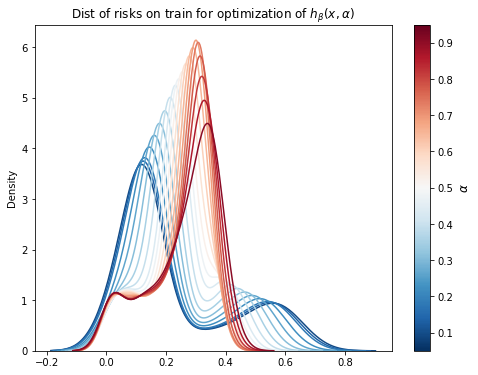

In [10]:
# Instantiate the target network and hypernetwork
target_net = TargetNetwork(input_dim=dim, output_dim=1)
h = HyperNetwork(target_net, hyper_input_dim=1, hyper_hidden_dims=[10]).cuda()
#Run the ARM regression task
loss_fn = torch.nn.MSELoss()
results = pd.DataFrame(columns = ["alpha", "cvar"])
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8,6))
rg = torch.arange(0,1,0.05)
diverging_colors = sns.color_palette("RdBu", len(rg))
ARM_Regression(name=rho).fit_h(h, data_dict_train) 
h.eval()
j=1
for alpha in tqdm(rg):
    with torch.no_grad():
        risks = torch.stack([loss_fn(data_dict_train[e]['y'].cuda(), h(data_dict_train[e]['x'].cuda(), alpha.cuda())) for e in data_dict_train.keys()])
        cvar_emp = aggregation_function(name="cvar").aggregate(risks.cpu(), alpha.cpu())     
        sns.kdeplot(risks.cpu().numpy(), ax=ax,color=diverging_colors[len(rg)-j], label=str(alpha.item()))
        print("alpha: ", alpha, " CVaR: ",cvar_emp.item(), "param: ",h.target_net.fc.weight.data.item() )
    results.at[int(alpha.item()*100), "alpha"] = alpha
    results.at[int(alpha.item()*100), "cvar"] = cvar_emp
    j+=1
ax.legend(bbox_to_anchor=(1.02, 1.02), title=r"$\alpha$", loc='upper left')
ax.set_title(r"Dist of risks on train for optimization of $h_\beta(x,\alpha)$")
norm = plt.Normalize(0.05, 0.95)
sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=norm)
sm.set_array([])
ax.get_legend().remove()
ax.figure.colorbar(sm).set_label(label= r'$\alpha$',labelpad=5,size=12)